In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn import tree
from IPython.display import Image 
from io import StringIO
import pydotplus

In [8]:
user=pd.read_csv('./spanish _translation_abtest/user_table.csv')
test=pd.read_csv('./spanish _translation_abtest/test_table.csv')

In [11]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [12]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [66]:
# check uniqueness
print('Test ID:',len(test['user_id'].unique()),len(test['user_id'].unique())==len(test))
print('Test ID:',len(user['user_id'].unique()),len(user['user_id'].unique())==len(user))

print(len(test['user_id'].unique())-len(user['user_id'].unique()))

Test ID: 453321 True
Test ID: 452867 True
454


Looks like the user table is busted and we have some user ids missing. When joining, we have to be careful to do not lose the user ids in the test table, but not in the user table.

In [22]:
df=pd.merge(user,test,on='user_id')

In [39]:
df.describe()

,user_id,age,conversion,test
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,27.130740,0.049560,0.476462
std,288676.264784,6.776678,0.217034,0.499446
min,1.000000,18.000000,0.000000,0.000000
25%,249819.000000,22.000000,0.000000,0.000000
50%,500019.000000,26.000000,0.000000,0.000000
75%,749543.000000,31.000000,0.000000,1.000000
max,1000000.000000,70.000000,1.000000,1.000000


# A/B test

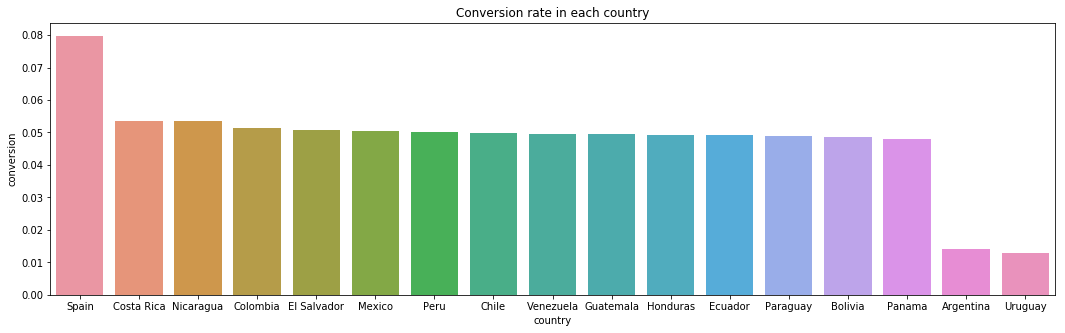

In [67]:
# First question is: check test results. But even before that, let’s make sure it is true Spain converts much better than the rest of LatAm countries.
groupby_country=df.groupby('country')['conversion'].mean().reset_index().sort_values('conversion', ascending=False)

fig,ax=plt.subplots(figsize=(18,5))
ax=sns.barplot(x='country',y='conversion',data=groupby_country)
ax.set_title('Conversion rate in each country')
plt.show()

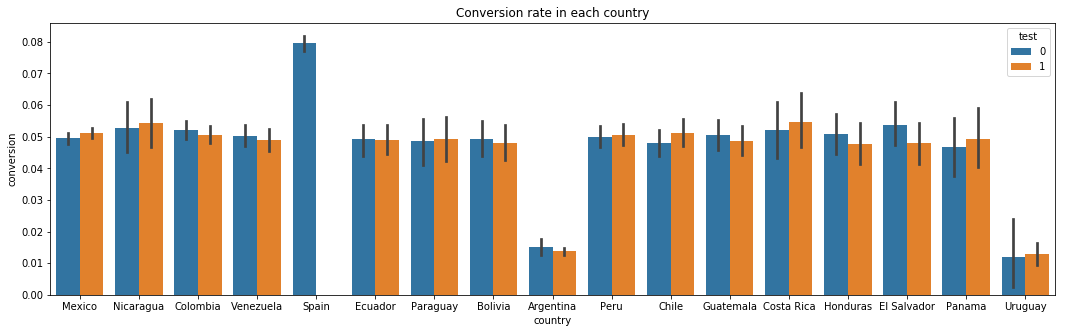

In [49]:
fig,ax=plt.subplots(figsize=(18,5))
ax=sns.barplot(x='country',y='conversion',hue='test',data=df)

plt.show()

Two-Sample T-Test

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. Unlike the one sample-test where we test against a known population parameter, the two sample test only involves sample means. You can conduct a two-sample t-test by passing with the stats.ttest_ind() function. 

H0: conversion_rate(control)=conversion_rate(experiment)

Ha: conversion_rate(control)<>conversion_rate(experiment)

In [65]:
experiment=df[(df.country!='Spain') & (df.test==1)]['conversion'].values
control=df[(df.country!='Spain') & (df.test==0)]['conversion'].values

print(experiment.mean(),control.mean())

print(ttest_ind(a=experiment,b=control, equal_var=False))

## equal_var : bool, optional
## If True (default), perform a standard independent 2 sample test that assumes equal population variances 
## If False, perform Welch’s t-test, which does not assume equal population variance


0.043411161678422794 0.04829179055749524
Ttest_indResult(statistic=-7.353895203080277, pvalue=1.928917857779903e-13)


Not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop,which would be dramatic if it were true. The most likely reason for weird A/B test results are:
    
    We didn’t collect enough data.
    Some bias has been introduced in the experiment so that test/control people are not really random.

### In data science, whenever results appear too bad or too good to be true, they are not true.

In [110]:
t=df[(df.country!='Spain') & (df.test==1)].groupby('date')[['conversion']].mean().reset_index()
c=df[(df.country!='Spain') & (df.test==0)].groupby('date')[['conversion']].mean().reset_index()
test_vs_control=pd.merge(t,c,on='date')
test_vs_control['t/c']=test_vs_control['conversion_x']/test_vs_control['conversion_y']

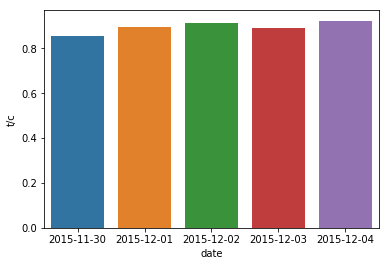

In [111]:
fig,ax=plt.subplots()
ax=sns.barplot(x=test_vs_control.date,y=test_vs_control['t/c'])
plt.show()

1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.

In [134]:
X=df[['user_id','date','source','device','browser_language','ads_channel','browser','sex','age','country']]
X=pd.get_dummies(X)
y=df['test']
clf=tree.DecisionTreeClassifier(random_state=0,max_depth=3)
clf=clf.fit(X,y)

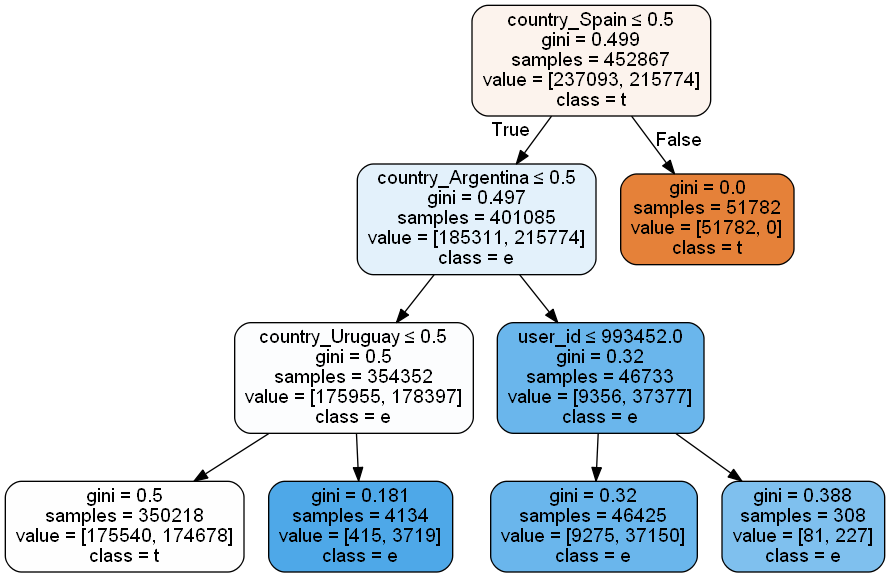

In [135]:
def plot_decision_tree(clf,feature_name,target_name):
    dot_data=StringIO()
    tree.export_graphviz(clf,out_file=dot_data,
                        feature_names=feature_name,
                        class_names=target_name,
                        filled=True,rounded=True,
                        special_characters=True)
    graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

plot_decision_tree(clf,X.columns,'test')


In an ideal world, the distribution of people in test and control for each segment should be the same. The decision tree splits on variable 'country' means that for given values it's more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).


In [142]:
countries=[name for name in df['country'].unique() if name is not (np.nan and 'Spain')]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)

for i in countries:
    test_group=df[(df.country==i) & (df.test==1)]['conversion'].values
    control_group=df[(df.country==i) & (df.test==0)]['conversion'].values
    
    test_mean=test_group.mean()
    control_mean=control_group.mean()
    p_val=ttest_ind(test_group,control_group,equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(i, test_mean, control_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Nicaragua               0.05418         0.05265   0.780400
Colombia                0.05057         0.05209   0.423719
Venezuela               0.04898         0.05034   0.573702
Spain                       nan         0.07972        nan


C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ecuador                 0.04899         0.04915   0.961512
Paraguay                0.04923         0.04849   0.883697
Bolivia                 0.04790         0.04937   0.718885
Argentina               0.01373         0.01507   0.335147
Peru                    0.05060         0.04991   0.771953
Chile                   0.05130         0.04811   0.302848
Guatemala               0.04865         0.05064   0.572107
Costa Rica              0.05474         0.05226   0.687876
Honduras                0.04754         0.05091   0.471463
El Salvador             0.04795         0.05355   0.248127
Panama                  0.04937         0.04680   0.705327
Uruguay                 0.01291         0.01205   0.879764


After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!